In [1]:
import matplotlib.pyplot as plt
import imgviz
import os
from PIL import Image
import numpy as np
import json
from torch.utils.data import DataLoader, Dataset
from typing import Callable
from datasets import load_dataset
from transformers import AutoProcessor
import os
import requests
from PIL import Image
import random
import regex as re

import torch
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration
from torchvision.ops import box_iou

/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_device(is_ddp):
    if is_ddp:
        local_rank = int(os.environ["LOCAL_RANK"])
        device = torch.device("cuda:{}".format(local_rank))
        return device
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        return device
def get_rank_size(is_ddp: bool):
    if is_ddp:
        local_rank = int(os.environ["LOCAL_RANK"])
        world_rank = int(os.environ["RANK"])  # dist.get_rank()
        world_size = int(os.environ["WORLD_SIZE"])
        return local_rank, world_rank, world_size
    else:
        return 0, 0, 1

def get_dataloader(
    is_ddp: bool,
    dataset: Dataset,
    shuffle: bool,
    loader_drop_last: bool,
    batch_size: int,
    num_workers: int,
    collate_fn: Callable,
    pin_memory: bool = None,
    world_size: int = None,
    world_rank: int = None,
    seed: int = None,
    sampler_drop_last: bool | None = None,
):
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(seed)

    if is_ddp:
        sampler = torch.utils.data.distributed.DistributedSampler(
            dataset, num_replicas=world_size, rank=world_rank, shuffle=shuffle, drop_last=sampler_drop_last, seed=seed
        )
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
            drop_last=loader_drop_last,
            sampler=sampler,
            worker_init_fn=seed_worker,
            generator=g,
        )
    else:
        return DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=pin_memory,
            collate_fn=collate_fn,
            shuffle=shuffle,
            drop_last=loader_drop_last,
            worker_init_fn=seed_worker,
            generator=g,
        )
        
class RefCOCODataset(Dataset):
    def __init__(self, dataset, image_folder_root):
        self.dataset = dataset
        self.image_folder_root = image_folder_root

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        raw_image_info = json.loads(sample["raw_image_info"])
        image_file_name = raw_image_info["file_name"]
        original_image_width_height = (raw_image_info["width"], raw_image_info["height"])
        image_path = os.path.join(self.image_folder_root,image_file_name)
        image = Image.open(image_path).convert("RGB")
        bbox = sample["bbox"]
        caption_list = [sentences["raw"] for sentences in sample["sentences"]]
        
        return image, caption_list, bbox,original_image_width_height,image_file_name
    
def eval_collate_fn(batch):
    caption_list = []
    image_list = []
    bbox_list = []
    original_image_width_height_list = []
    image_file_name_list = []
    for image, caption, bbox, original_image_width_height, image_file_name in batch:
        image_list.append(image)
        caption_list.append(caption)
        bbox_list.append(bbox)
        original_image_width_height_list.append(original_image_width_height)
        image_file_name_list.append(image_file_name)
        
    return image_list, caption_list, bbox_list, original_image_width_height_list,image_file_name_list

def fix_seed(seed: int) -> None:
    """
    seedをする

    Args:
        seed (int): seed値
    """
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)  # cpuとcudaも同時に固定
    torch.cuda.manual_seed(seed)  # 上記で呼び出される
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    
    
def llava_onevision_conversation(caption):
    conversation = [
        {

        "role": "system",
        "content": [
            {"type": "text", "text": "You are a helpful assistant."},
            ],
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"Provide the bounding box coordinate of the region this sentence describes. \"{caption}\""},
                {"type": "image"},
            ],
        }
    ]
    
    return conversation

def make_prompt_list(caption_list,processor):
    prompt_list = []
    for caption in caption_list:
        conversation = llava_onevision_conversation(caption)
        prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
        prompt_list.append(prompt)
    return prompt_list



def extract_bbox_from_text(ans):
    pattern = re.compile(r'\[(((0|1)\.(\d){3}\,){3}((0|1)\.(\d){3}))\]')
    match_list = pattern.findall(ans)

    if len(match_list) > 0:
        answer = [list(map(float,match[0].split(","))) for match in match_list]
    else:
        answer = "FAILED"
    return answer

def bbox_relative_to_absolute(relative_bbox, original_image_width_height):
    original_width, original_height = original_image_width_height
    x1 = relative_bbox[0] * original_width
    y1 = relative_bbox[1] * original_height
    x2 = relative_bbox[2] * original_width
    y2 = relative_bbox[3] * original_height
    absolute_bbox = [x1, y1, x2, y2]
    return absolute_bbox


def get_bbox_from_output(output_text, original_image_width_height_list):
    output_bbox_list = []
    for i in range(len(output_text)):
        relative_bbox = extract_bbox_from_text(output_text[i])[0]
        absolute_bbox = bbox_relative_to_absolute(relative_bbox, original_image_width_height_list[i])
        output_bbox_list.append(absolute_bbox)
    return output_bbox_list

def calculate_iou(bbox_list1, bbox_list2):
    """
    Calculate IoU for two lists of bounding boxes.

    Args:
        bbox_list1 (list): List of bounding boxes in the format [x1, y1, x2, y2].
        bbox_list2 (list): List of bounding boxes in the format [x1, y1, x2, y2].

    Returns:
        torch.Tensor: IoU matrix where each element (i, j) represents the IoU between bbox_list1[i] and bbox_list2[j].
    """
    iou_matrix = box_iou(torch.tensor(bbox_list1).float(), torch.tensor(bbox_list2).float())
    iou_list = iou_matrix.diagonal().tolist()
    return iou_list

def create_jsonl_file(file_path):
    """
    Create an empty JSONL file.

    Args:
        file_path (str): Path to the JSONL file.
    """
    with open(file_path, 'w') as f:
        pass

def append_to_jsonl(file_path, data):
    """
    Append a dictionary as a JSON object to a JSONL file.

    Args:
        file_path (str): Path to the JSONL file.
        data (dict): Dictionary to append as a JSON object.
    """
    with open(file_path, 'a') as f:
        json.dump(data, f)
        f.write('\n')

def save_json(file_path, data):
    """
    Save data to a JSON file.

    Args:
        file_path (str): Path to the JSON file.
        data (dict): Data to save.
    """
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)

In [3]:
fix_seed(0)
device = get_device(is_ddp=False)

model_root_dir = "/home/omote/local-share-data_ssd/huggingface_model_weights"
model_id = os.path.join(model_root_dir, "llava-hf/llava-onevision-qwen2-7b-si-hf")
cache_dir = "/home/omote/local-share-data_ssd/huggingface_cache"

processor = AutoProcessor.from_pretrained(model_id, cache_dir=cache_dir)
processor.tokenizer.padding_side = "left"

model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id, cache_dir=cache_dir, torch_dtype=torch.bfloat16
)
model.eval()
model.to(device)

dataset_root_dir = "/home/omote/local-share-data_ssd/huggingface_dataset"
image_folder_root = "/home/omote/local-share-data/mscoco2014/train2014"


dataset_id = os.path.join(dataset_root_dir,"jxu124/refcoco")
dataset = load_dataset(dataset_id, cache_dir=cache_dir)


eval_dataset_key = ["validation","test","testB"]
eval_dataset_dict = {k: RefCOCODataset(dataset[k],image_folder_root) for k in eval_dataset_key}



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading checkpoint shards: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


In [4]:
eval_dataset = eval_dataset_dict["validation"]
eval_dataloader = DataLoader(
        eval_dataset,
        batch_size=16,
        num_workers=0,
        pin_memory=False,
        collate_fn=eval_collate_fn,
        shuffle=False,
        drop_last=False,
)


In [5]:
print(next(iter(eval_dataloader)))

([<PIL.Image.Image image mode=RGB size=640x428 at 0x1464C87E39E0>, <PIL.Image.Image image mode=RGB size=640x428 at 0x1464C87C8800>, <PIL.Image.Image image mode=RGB size=640x481 at 0x1464C87E2960>, <PIL.Image.Image image mode=RGB size=640x481 at 0x1464C87E2090>, <PIL.Image.Image image mode=RGB size=427x640 at 0x1464C87CA7E0>, <PIL.Image.Image image mode=RGB size=427x640 at 0x1464C87E2D50>, <PIL.Image.Image image mode=RGB size=640x427 at 0x1464C87C9430>, <PIL.Image.Image image mode=RGB size=372x500 at 0x1464C87C9B20>, <PIL.Image.Image image mode=RGB size=372x500 at 0x1464CBC93410>, <PIL.Image.Image image mode=RGB size=372x500 at 0x1464C8806EA0>, <PIL.Image.Image image mode=RGB size=372x500 at 0x1464C87E22A0>, <PIL.Image.Image image mode=RGB size=480x640 at 0x1464C87E14F0>, <PIL.Image.Image image mode=RGB size=480x640 at 0x1464C87573B0>, <PIL.Image.Image image mode=RGB size=640x360 at 0x1464C87B40E0>, <PIL.Image.Image image mode=RGB size=640x360 at 0x1464C87E21E0>, <PIL.Image.Image image 

In [6]:



model_output_jsonl_path = os.path.join("./","llava_onevision_refcoco.jsonl")
score_json_path = os.path.join("./","llava_onevision_refcoco_score.json")
create_jsonl_file(model_output_jsonl_path)

iou_list = []
for image_list, caption_list, bbox_list, original_image_width_height_list,image_file_name_list in eval_dataloader:
    caption_list = [caption[0] for caption in caption_list]
    prompt_list = make_prompt_list(caption_list,processor)
    inputs = processor(images=image_list, text=prompt_list, return_tensors='pt',padding=True,truncation=True)
    inputs = inputs.to(model.device)
    output = model.generate(**inputs, max_new_tokens=400, do_sample=False,temperature=0)
    output_text = processor.batch_decode(output, skip_special_tokens=False,)
    
    model_bbox_list = get_bbox_from_output(output_text, original_image_width_height_list)
    iou_list = calculate_iou(bbox_list, model_bbox_list)
    print(iou_list)
    for i in range(len(image_file_name_list)):
        image_file_name = image_file_name_list[i]
        caption = caption_list[i]
        bbox = bbox_list[i]
        model_bbox = model_bbox_list[i]
        iou = iou_list[i]
        
        data = {
            "image_file_name": image_file_name,
            "caption": caption,
            "bbox": bbox,
            "model_bbox": model_bbox,
            "iou": iou
        }
        
        append_to_jsonl(model_output_jsonl_path, data)
    iou_list.extend(iou_list)
    break

iou_list = np.array(iou_list)
mean_iou = np.mean(iou_list)
print(f"Mean IoU: {mean_iou}")
save_json(score_json_path, {"mean_iou": mean_iou})
    
    

/home/omote/cluster_project/iam2/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.


[0.9012407660484314, 0.9062215089797974, 0.7793456315994263, 0.8974684476852417, 0.8967190384864807, 0.8821678161621094, 0.8639248013496399, 0.7710025310516357, 0.7717152833938599, 0.6835335493087769, 0.8546993732452393, 0.814435601234436, 0.8453680872917175, 0.8301383852958679, 0.8763443827629089, 0.8887327909469604]
Mean IoU: 0.8414411246776581


In [8]:
for text in output_text:
    print(text[-50:])

art|>assistant
[0.730,0.000,1.000,0.250]<|im_end|>
art|>assistant
[0.264,0.327,0.912,0.986]<|im_end|>
art|>assistant
[0.156,0.596,0.444,0.988]<|im_end|>
art|>assistant
[0.431,0.208,0.923,0.988]<|im_end|>
art|>assistant
[0.336,0.272,0.894,0.936]<|im_end|>
art|>assistant
[0.369,0.397,0.634,0.736]<|im_end|>
art|>assistant
[0.000,0.085,0.502,0.988]<|im_end|>
art|>assistant
[0.550,0.000,0.998,0.481]<|im_end|>
art|>assistant
[0.078,0.566,0.456,0.988]<|im_end|>
art|>assistant
[0.080,0.069,0.500,0.500]<|im_end|>
art|>assistant
[0.350,0.555,1.000,0.988]<|im_end|>
art|>assistant
[0.336,0.116,0.556,0.316]<|im_end|>
art|>assistant
[0.336,0.720,0.872,0.988]<|im_end|>
art|>assistant
[0.472,0.066,0.658,0.956]<|im_end|>
art|>assistant
[0.097,0.252,0.486,0.986]<|im_end|>
art|>assistant
[0.316,0.686,0.783,0.988]<|im_end|>


In [7]:
print(original_image_width_height_list)
print(bbox_list)

[(640, 428), (640, 428), (640, 481), (640, 481)]
[[468.3, 0.91, 640.0, 117.03], [151.96, 139.46, 606.89, 423.19000000000005], [117.82, 300.49, 292.91999999999996, 481.0], [289.68, 110.25, 580.44, 475.6]]


In [9]:
print(output_text[1][-50:])
print(prompt_list)

art|>assistant
[0.250,0.327,0.912,0.988]<|im_end|>
['<|im_start|>system \nYou are a helpful assistant.<|im_end|><|im_start|>user <image>\nProvide the bounding box coordinate of the region this sentence describes. "bowl behind the others can only see part"<|im_end|><|im_start|>assistant\n', '<|im_start|>system \nYou are a helpful assistant.<|im_end|><|im_start|>user <image>\nProvide the bounding box coordinate of the region this sentence describes. "front bowl w/carrots in it"<|im_end|><|im_start|>assistant\n', '<|im_start|>system \nYou are a helpful assistant.<|im_end|><|im_start|>user <image>\nProvide the bounding box coordinate of the region this sentence describes. "little girl"<|im_end|><|im_start|>assistant\n', '<|im_start|>system \nYou are a helpful assistant.<|im_end|><|im_start|>user <image>\nProvide the bounding box coordinate of the region this sentence describes. "green woman"<|im_end|><|im_start|>assistant\n']


In [10]:
print(output_bbox_list)

[[472.96, 0.0, 640.0, 98.86800000000001], [160.0, 139.95600000000002, 583.6800000000001, 422.864], [97.92, 279.46099999999996, 286.08, 475.228], [275.84, 100.048, 586.88, 475.228]]


In [11]:
print(bbox_list)

[[468.3, 0.91, 640.0, 117.03], [151.96, 139.46, 606.89, 423.19000000000005], [117.82, 300.49, 292.91999999999996, 481.0], [289.68, 110.25, 580.44, 475.6]]


In [12]:
import imgviz
def visualize_bbox(image, bbox, caption):
    bboxes = np.array([bbox[1],bbox[0],bbox[3],bbox[2]]).astype(np.int32).reshape(-1, 4)
    labels = [2]
    image = imgviz.instances2rgb(np.array(image), bboxes=bboxes, labels=labels,captions=[caption],font_size=16)

    plt.imshow(image)
    plt.show()

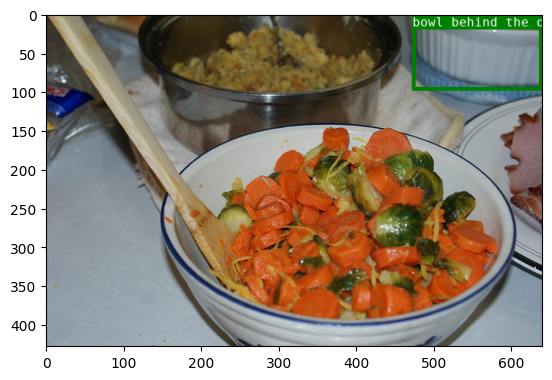

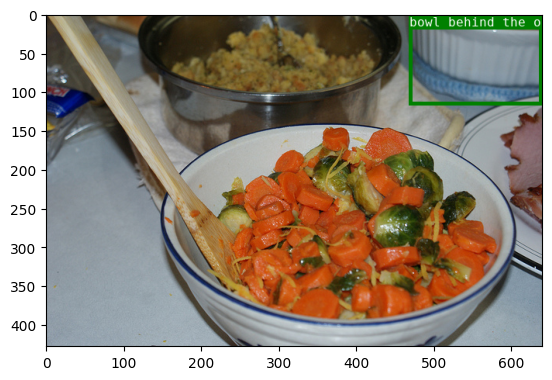

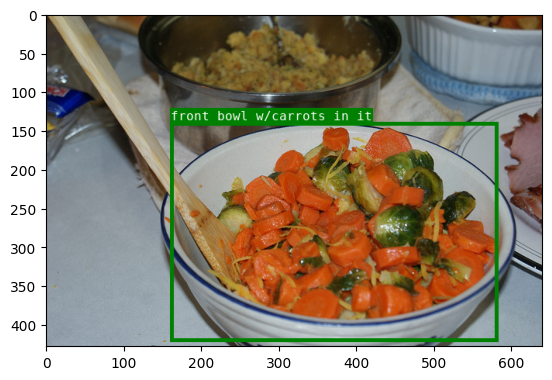

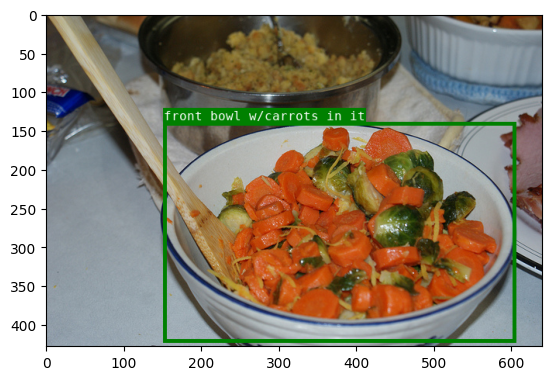

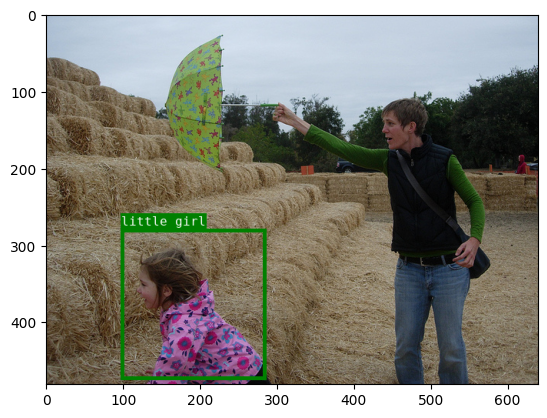

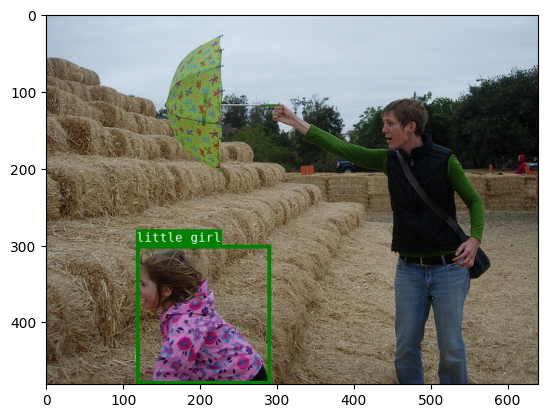

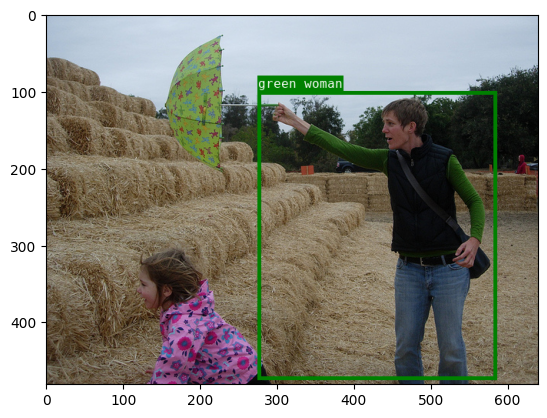

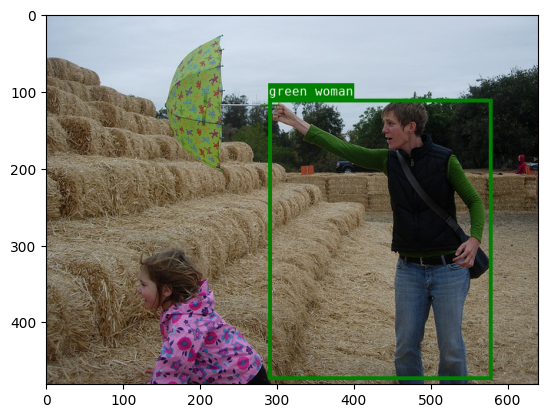

In [13]:
for i in range(len(image_list)):
    visualize_bbox(image_list[i], output_bbox_list[i], caption_list[i])
    visualize_bbox(image_list[i], bbox_list[i], caption_list[i])

In [14]:
print(len(output_bbox_list[0]))

4


[0.8144877552986145, 0.92861008644104, 0.7530828714370728, 0.9085379838943481]
